# Final Project Part 3

#### Table of Contents
- [Inference](#Inference)
- [Prediction](#Prediction)
- [Comparison](#Comparison)

## Inference

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import statsmodels.api as sm
import sklearn.linear_model as lm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


import seaborn as sns
sns.set(rc = {'axes.titlesize': 24,
             'axes.labelsize': 20,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'figure.figsize': (12, 6)})


In [3]:
sic = pd.read_pickle('sic_fp.pkl')
sic.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24676 entries, (2011, 1958) to (3999, 2011)
Data columns (total 9 columns):
l_vadd       24676 non-null float64
l_emp        24676 non-null float64
l_invest     24676 non-null float64
l_pay        24676 non-null float64
l_matcost    24676 non-null float64
l_vship      24676 non-null float64
l_cap        24676 non-null float64
l_invent     24676 non-null float64
l_energy     24676 non-null float64
dtypes: float64(9)
memory usage: 1.8 MB


In [5]:
y = sic['l_vadd']
x = sic.drop(columns = 'l_vadd')

y_train, y_test = train_test_split(y, train_size = 3/4, random_state = 490)
x_train, x_test = train_test_split(x, train_size = 3/4, random_state = 490)

ss = StandardScaler()
x_train_std = pd.DataFrame(ss.fit(x_train).transform(x_train),
                          columns = x_train.columns,
                          index = x_train.index) 
x_test_std = pd.DataFrame(ss.fit(x_test).transform(x_test),
                          columns = x_test.columns,
                          index = x_test.index) 

x_train_std_c     = sm.add_constant(x_train_std)
x_test_std_c      = sm.add_constant(x_test_std)
x_train_c    = sm.add_constant(x_train)
x_test_c     = sm.add_constant(x_test)

C:\Users\tanse\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [6]:
param_grid = [
    {'alpha': 10**np.linspace(-6, -4, num = 10)}
]


cv_lasso = lm.Lasso(fit_intercept = False, normalize = False,
                    random_state = 490)
grid_search = GridSearchCV(cv_lasso, param_grid, cv = 5,
                         scoring = 'neg_root_mean_squared_error')
grid_search.fit(x_train_std_c, y_train)
best = grid_search.best_params_['alpha']
best

2.782559402207126e-06

In [7]:
fit_lasso_tuned = sm.OLS(y_train, x_train_std_c).fit_regularized(alpha = best) 
beta = fit_lasso_tuned.params #fitting on non regularized standardized model
beta.index[beta == 0]
x_train_trim = x_train_std_c.loc[:, ~x_train_std_c.columns.isin(beta.index[beta == 0])]
x_test_trim = x_test_std_c.loc[:, ~x_test_std_c.columns.isin(beta.index[beta == 0])]

In [8]:
fit_std_final = sm.OLS(y_train, x_train_trim).fit() #testing on non-regularized values
fit_std_final.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.993      
Dependent Variable: l_vadd           AIC:                -26272.1018
Date:               2021-05-11 10:18 BIC:                -26201.6686
No. Observations:   18507            Log-Likelihood:     13145.     
Df Model:           8                F-statistic:        3.253e+05  
Df Residuals:       18498            Prob (F-statistic): 0.00       
R-squared:          0.993            Scale:              0.014151   
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           6.7547    0.0009  7724.5430  0.0000   6.7530   6.7564
l_emp          -0.0319    0.0019   -16.7239  0.0000  -0.0356  -0.0281
l_invest        0.0604    0.0032    19.0809  0.0000   0.0542   0.0666
l_pay           0.2437    0.0042    57.7686  0.0000   0.2354   0.2519
l_matcost      -1.2478    0.0064  -195.6550  0.0000  -1.2603  -1.2353
l_vship         2.3447    0.0089   264.7884  0.0000   2.3273   2.3620
l_cap          -0.0217    0.0025    -8.6475  0.0000  -0.0266  -0.0167
l_invent        0.0372    0.0025    14.7130  0.0000   0.0322   0.0421
l_energy       -0.0127    0.0024    -5.3406  0.0000  -0.0173  -0.0080
--------------------------------------------------------------------
Omnibus:            12515.174      Durbin-Watson:         2.025     
Prob(Omnibus):      0.000          Jarque-Bera (JB):      310124.657
Skew:               -2.905         Prob(JB):              0.000     
Kurtosis:           22.194         Condition No.:         33        
====================================================================

"""

Top three most significant variables are l_vship, l_matcost, and l_pay, each with extremely high t statistics.
- l_vship: A one percent increase in the total value of shipments is associated with a decrease of total value added by 2.2908 percent.
- l_matcost: A one percent increase in the total cost of materials is associated with a decrease of total value added by 1.2348 percent.
- l_pay:  A one percent increase in the total payroll is associated with an increase of total value added by 0.2384 percent.

In [9]:
rmse_ols = np.sqrt(np.mean((y_test - fit_std_final.predict(x_test_trim))**2))
rmse_ols

0.11483983674229031

## Prediction
[TOP](#Final-Project-Part-3)

### *SVM*

In [ ]:
# param_grid = {
#     'degree': [1,2,3],
#     'C': 10. ** np.arange(0,2),
#     'epsilon': 10. ** np.arange(-1,1)
# }
# svr_cv = SVR(kernel = 'poly')
# grid_search = GridSearchCV(svr_cv, param_grid, cv = 5, 
#                          scoring = 'neg_root_mean_squared_error')
# grid_search.fit(x_train_std, y_train)
# best = grid_search.best_params_
# best
??xgb.XGBRegressor

In [10]:
param_grid = {
    'C': 10.0 ** np.arange(-1, 3 , step = 1),
    'degree': [1,2,3],
    'epsilon': 10.0 ** np.arange(-3, 0 , step = 1)
}

In [ ]:
svmc_cv = SVR(kernel = 'poly')
grid_search = GridSearchCV(svmc_cv, param_grid,
                          cv = 5,
                          scoring = 'neg_root_mean_squared_error').fit(x_train, y_train)
best = grid_search.best_params_
best

In [22]:
svr_poly = SVR(kernel = 'poly', degree = best['degree'],
              C = best['C'], epsilon = best['epsilon'])
svr_poly.fit(x_train_std, y_train)

rmse_poly = np.sqrt(np.mean((y_test - svr_poly.predict(x_test_std))**2))
rmse_poly

0.12491944205883838

### *XGBoost*

In [6]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train_std, y_train, 
                                                                            train_size = 1/2,
                                                                           random_state = 490)

In [7]:
clf_xgb = xgb.XGBRegressor(n_estimators = 750, max_depth = 6, learning_rate = 0.1,
                          random_state = 490, use_label_encoder = False)
clf_xgb.fit(x_train_train, y_train_train, eval_set = [(x_train_test, y_train_test)],
           early_stopping_rounds = 5)

[0]	validation_0-rmse:5.77151
[1]	validation_0-rmse:5.19649
[2]	validation_0-rmse:4.67859
[3]	validation_0-rmse:4.21337
[4]	validation_0-rmse:3.79459
[5]	validation_0-rmse:3.41731
[6]	validation_0-rmse:3.07821
[7]	validation_0-rmse:2.77316
[8]	validation_0-rmse:2.49860
[9]	validation_0-rmse:2.25194
[10]	validation_0-rmse:2.02966
[11]	validation_0-rmse:1.82977
[12]	validation_0-rmse:1.65021
[13]	validation_0-rmse:1.48836
[14]	validation_0-rmse:1.34290
[15]	validation_0-rmse:1.21192
[16]	validation_0-rmse:1.09413
[17]	validation_0-rmse:0.98799
[18]	validation_0-rmse:0.89279
[19]	validation_0-rmse:0.80693
[20]	validation_0-rmse:0.72975
[21]	validation_0-rmse:0.66041
[22]	validation_0-rmse:0.59834
[23]	validation_0-rmse:0.54284
[24]	validation_0-rmse:0.49299
[25]	validation_0-rmse:0.44822
[26]	validation_0-rmse:0.40824
[27]	validation_0-rmse:0.37259
[28]	validation_0-rmse:0.34087
[29]	validation_0-rmse:0.31251
[30]	validation_0-rmse:0.28722
[31]	validation_0-rmse:0.26500
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=750, n_jobs=12, num_parallel_tree=1, random_state=490,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [8]:
xgb_n_est = clf_xgb.best_iteration
xgb_n_est

664

In [9]:
clf_xgb = xgb.XGBRegressor(n_estimators = xgb_n_est, max_depth = 5,
                          learning_rate = 0.1, random_state = 490,
                          use_label_encoder = False)
clf_xgb.fit(x_train_std, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=664, n_jobs=12, num_parallel_tree=1, random_state=490,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [17]:
rmse_xgb = np.sqrt(np.mean((y_test - clf_xgb.predict(x_test_std))**2))
rmse_xgb

0.06475533035641769

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

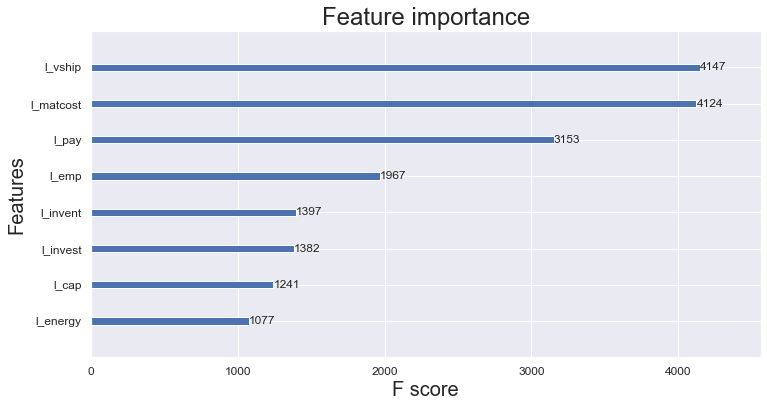

In [17]:
xgb.plot_importance(clf_xgb, importance_type = 'weight')

### *Random Forest*

In [18]:
clf_rf = RandomForestRegressor(n_estimators = 1000,
                          random_state = 490,
                          max_features = 'sqrt',
                          oob_score = True)
clf_rf.fit(x_train_std, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=1000, oob_score=True,
                      random_state=490)

In [19]:
rmse_rf = np.sqrt(np.mean((y_test - clf_rf.predict(x_test_std))**2))
rmse_rf

0.10929388013954283

In [32]:
print(rmse_ols, rmse_poly, rmse_xgb, rmse_rf)

0.11483983674229031 0.12491944205883838 0.06475533035641769 0.10929388013954283


## Comparison
[TOP](#Final-Project-Part-3)

<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>OLS</td>
      <td>0.12736127258697186</td>
    </tr>
    <tr>
      <td>Support Vector Regression</td>
      <td>0.12668720173565048</td>
    <tr>
      <td>Extreme Gradient Boosting</td>
      <td>0.14921002612012657</td>
    <tr> 
      <td>Random Forest</td>
      <td>0.215241474310346</td>
    </tr>
  </tbody>
</table>


When compared to random forest, gradient boosting develops itself in each model, instead of independently like random forest. Extreme Gradient Boosting can be more flexible, but can run into issues quickly with overfitting the data if the hyperparameters are improperly tuned. Similarly, if a support vector regression uses an improper kernel it will be less accurate than extreme gradient boosting. Again, extreme gradient boosting likely comes out ahead due to its adaptive nature throughout its processing. Support vector machines are much more sensitive to outliers, so in cases with high variation or outliers random forest would be a better choice over the svm’s.

OLS is the easiest to interpret as x and y are both able to be evaluated against the predicted values from the estimated coefficients. Random forests can be interpreted through the model's fitted important features, which indicate a closer relationship between the dependent variable and the feature in question. Extreme gradient boosting follows this interpretation, but tries to improve and change the weighting for each model off of the previous model.

For this data, the polynomial support vector machine worked the best, having the lowest rmse over any of the models fitted.